<a href="https://colab.research.google.com/github/sorijos/python-para-datascience-primeros-pasos/blob/main/Laboratorio_2_Clasificacion_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 2: Clasificación

_CC66N -- 7 de octubre de 2019_

1. Haga una copia de este notebook y responda donde se indica
2. Ejecute cada uno de los bloques de código, y modifíquelos según corresponda.
2. Al final de la sesión, descargue este notebook como un archivo **.ipynb** y súbalo a U-Cursos.

# Cargar datos


Ejecute el siguiente bloque para descargar los datos.


In [ ]:
!wget https://users.dcc.uchile.cl/~mquezada/diplomado-2018/default_payments_data.csv

--2019-10-07 23:22:35--  https://users.dcc.uchile.cl/~mquezada/diplomado-2018/default_payments_data.csv
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2897294 (2.8M) [text/csv]
Saving to: ‘default_payments_data.csv’

default_payments_da 100%[===================>]   2.76M  2.03MB/s    in 1.4s    

2019-10-07 23:22:37 (2.03 MB/s) - ‘default_payments_data.csv’ saved [2897294/2897294]



# Parte 1: Clasificación

Los datos corresponden a comportamiento de pago de tarjeta de crédito. Las columnas relevantes son las siguientes:

- LIMIT_BAL: Monto del crédito
- SEX: 1: hombre, 2: mujer
- MARRIAGE: 1: casado, 2: soltero, 3: otro
- EDUCATION: 1: postgrado, 2: universitario, 3: ed. media, 4: otros
- PAY_0...PAY_6: Historial de pagos anteriores, numero de meses de retraso o de pago adelantado
- BILL_AMT_1...BILL_AMT6: Valores de la cuenta de 6 meses
- PAY_AMT1...PAY_AMT6: Pagos de la cuenta de 6 meses
- **default payment next month**: indica si la persona no pagó al mes siguiente (1) o si pagó (0)

Cargamos los datos y desplegamos las primeras 5 filas

In [ ]:
import pandas as pd


df = pd.read_csv('default_payments_data.csv', skiprows=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Distribución de clases (dadas por la última columna, `default payment next month`)


In [ ]:
# distribucion de clases
# vemos que estan en relacion ~ 4:1

df['default payment next month'].value_counts()


0    23364
1     6636
Name: default payment next month, dtype: int64

Separamos los datos en X e y (data y target)

In [ ]:
# separamos los datos en X e y:
# para X, no consideramos ni la columna ID ni la ultima columna
X = df.loc[:, 'LIMIT_BAL':'PAY_AMT6']


y = df['default payment next month']

Separamos los datos en dataset de entrenamiento (train) y de evaluación (test) y vemos la distribución de clases

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.33,
                                                    random_state=37,
                                                    stratify=y)

print("Distribución de clases en train:")
print(y_train.value_counts())

print()

print("Distribución de clases en test")
print(y_test.value_counts())


Distribución de clases en train:
0    15654
1     4446
Name: default payment next month, dtype: int64

Distribución de clases en test
0    7710
1    2190
Name: default payment next month, dtype: int64


## Pregunta 1

**Edite el código abajo, completando donde se indica, de manera de entrenar un árbol de decisión y evaluarlo.**

**Explique brevemente, ¿qué hace `clf.fit` y `clf.predict`?**

In [ ]:
## EDITAR DONDE SE INDICA

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score


clf = DecisionTreeClassifier(random_state=37)
clf = clf.fit(X_train, y_train)  # <-----


y_pred = clf.predict(X_test)   # <------

print("Accuracy:", accuracy_score(y_test, y_pred))

Hacer doble click aquí para editar el bloque y escribir su respuesta


`clf.fit`:

`clf.predict`:

## Pregunta 2

**Proponga un clasificador simple que obtenga mejor accuracy en el test set.**

Hacer doble click sobre este bloque para editarlo y escribir su respuesta

## Pregunta 3

**Dado el siguiente reporte de clasificación, explique brevemente qué significa que la clase `1` tenga un 40% (0.4) de recall con respecto a los datos**.

In [ ]:
print(classification_report(y_test, y_pred))

Hacer doble click sobre este bloque para editarlo y escribir su respuesta

# Parte 2: Selección de modelo y cross-validation

El siguiente código calcula la precisión para la clase 1 en el conjunto de entrenamiento, la precisión usando 5-folds cross-validation, y la precisión en el conjunto de prueba que separamos inicialmente.

En este caso, calcula la precisión para muchos valores distintos de uno de los parámetros del árbol de decisión, el `min_samples_leaf`. Este parámetro determina cuántos elementos quedarán en las hojas (los nodos finales) del árbol. Un valor alto indica que en las hojas puede haber varias instancias (filas, observaciones) de los datos, por lo que posiblemente no están todas bien clasificadas. Por el contrario, un valor bajo indica que el entrenamiento tratará de clasificar más instancias de forma correcta. Observa que un valor bajo implica un modelo más complejo.


In [ ]:
## Ejecutar (no modificar) este código
## (demora unos 30 segundos en Colab)
## te recomiendo leer este código con sus comentarios después del laboratorio para entender mejor qué se está haciendo


from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

import numpy as np


### definimos un diccionario donde guardaremos los resultados

results = {
    "min_samples_leaf": [],  # el valor del parámetro
    "type": [],              # si es train, test, o cross-validation
    "score": []              # la precision [promedio]
}

min_samples_leaf_range = range(1, 211, 10)   # definimos un rango entre 1 y 201, cada 10, es decir: 1, 11, .. 201

for x in min_samples_leaf_range:   # iteramos sobre los elementos del rango
  clf = DecisionTreeClassifier(random_state=37, min_samples_leaf=x)  # instanciamos un arbol usando el parámetro min_samples_leaf de la iteración actual

  # cross_validate retorna un diccionario con las medidas en train, y "test" por cada fold (que corresponde al valor en el k-esimo fold usado para evaluar)
  scores_train_val = cross_validate(clf,      # el clasificador que queremos usar
                                    X_train,  # le pasamos los datos de entrenamiento para hacer cross-validation
                                    y_train,
                                    cv=5,     # 5 folds
                                    n_jobs=-1,                 # indica cuántas CPU queremos usar (para paralelizar el proceso), -1 indica que use todas las disponibles
                                    return_train_score=True,   # indica que retorne el score en el train set
                                    scoring="precision")       # scoring="precision" por defecto entrega la precision en la clase "1", que es lo que queremos en este caso

  precision_val = np.mean(scores_train_val['test_score'])     # promedio de los precision en el k-esimo fold (5 valores)
  precision_train = np.mean(scores_train_val['train_score'])  # promedio de los precision en el train set (5 valores)

  clf_ = clf.fit(X_train, y_train)       #  entrenamos el clasificador usando todo el train
  y_pred = clf_.predict(X_test)          #  ahora usamos el conjunto de evaluacion

  precision_test = precision_score(y_test, y_pred)    # computamos precision en el test set

  # guarda los resultados
  results['min_samples_leaf'].append(x)
  results['type'].append('train')
  results['score'].append(precision_train)

  results['min_samples_leaf'].append(x)
  results['type'].append('cross-validation')
  results['score'].append(precision_val)

  results['min_samples_leaf'].append(x)
  results['type'].append('test')
  results['score'].append(precision_test)

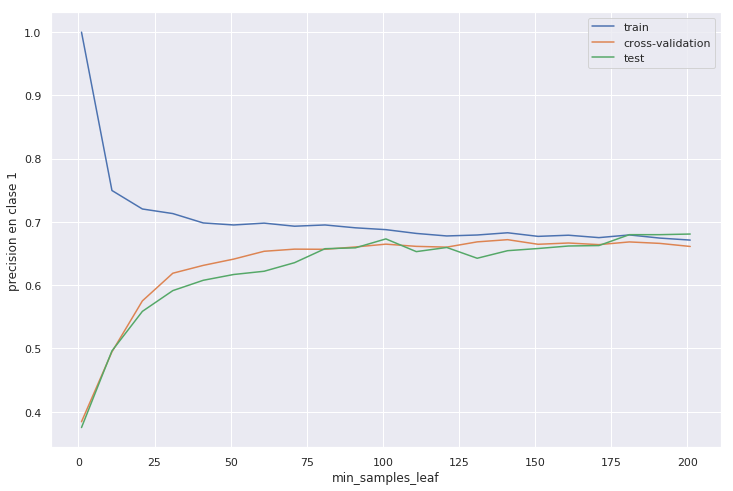

In [ ]:
## este codigo grafica los resultados a partir del bloque anterior


import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.figure(figsize=(12, 8))
ax = sns.lineplot(x="min_samples_leaf", y="score", hue="type", data=results)
ax.set(xlabel="min_samples_leaf", ylabel="precision en clase 1")

ax

## Pregunta 4

**A partir del gráfico anterior, indique ¿qué valor (aproximado) o rango de valores de `min_samples_leaf` considera que es apropiado para el modelo y por qué?**

Hacer doble click sobre este bloque para editarlo y escribir su respuesta



## Pregunta 5

**A partir del gŕafico, ¿Qué puede concluir con respecto a la relación entre el rendimiento del clasificador en el test set y el de cross-validation?**

Hacer doble click sobre este bloque para editarlo y escribir su respuesta



## Pregunta 6

**Usando el valor de `min_samples_leaf` escogido más arriba (o alguno dentro del rango escogido), y el mismo `random_state`, entrene un árbol de decisión.**

**Compare los reportes de clasificación entre este modelo y el usado al comienzo del laboratorio. El nuevo modelo, ¿en qué mejora?, ¿en qué empeora? Explique.**

In [ ]:
from sklearn.metrics import classification_report

MIN_SAMPLES_LEAF = ? # <---- indicar el valor de min_samples_leaf

clf = DecisionTreeClassifier(random_state=37, min_samples_leaf=MIN_SAMPLES_LEAF)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

Hacer doble click sobre este bloque para editarlo y escribir su respuesta



---



## Bonus opcional 1

El siguiente código genera una _curva de aprendizaje_, que muestra el rendimiento de un clasificador a medida que agregamos más datos.

Describa con sus palabras qué muestra el gráfico, y una observación sobre lo que está mostrando.

In [ ]:
## este código demora aprox. 1 minuto en Colab
## Fuente: https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(random_state=37, min_samples_leaf=120),
                                                        X,
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='precision',
                                                        # Use all computer cores
                                                        n_jobs=-1,
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Precision Score @ class 1"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Hacer doble click sobre este bloque para editarlo y escribir su respuesta



---



## Bonus opcional 2

Suponga que tenemos un dataset que consiste en una _serie de tiempo_, es decir, las observaciones siguen un orden específico, como por ejemplo, el precio de una acción en la bolsa o las condiciones del clima de una ciudad.

¿Por qué no es posible hacer holdout o cross-validation sobre este tipo de datos? Proponga una modificación a holdout y a cross-validation para poder trabajar sobre series de tiempo.

Hacer doble click sobre este bloque para editarlo y escribir su respuesta